In [1]:
import numpy as np
import re
import json
import matplotlib.pyplot as plt
from word2number.w2n import word_to_num

# Evaluation when output format digit

### preprocessing

In [2]:
MAX_DIGITS = 7

In [3]:
# need to prepocess the lines
processed_lines = []

rejected_lines = {'end with ?':[],'have no word form num':[]}

with open('gemini_response/Numeration_int_addition_digit_op_response.txt','r') as file:
    for line in file:
        # remove spaces and newlines
        line = line.strip()
        # some lines end with a question mark, and don't contain answers reject them
        if line.endswith('?'):
            rejected_lines['end with ?'].append(line)
            continue
        # some lines are empty, reject them
        if len(line) == 0:
            continue
        # some lines don't contain a single letter, reject them
        if re.match(r'^[^a-zA-Z]*$', line):
            rejected_lines['have no word form num'].append(line)
            continue
        # some lines have **Answer:** a{digit}+b{digit} = sum {digit}, reject them
        if line.startswith('**Answer'):
            rejected_lines['have no word form num'].append(line)
            continue
        # some lines start with what is a{word/digit}+b{word/digit} = a{digit}+b{digit} = sum {digit}
        # remove what is from them and the part between 2 equal signs
        if line.startswith('what is'):
            line = line.replace('what is ','')
            line = re.sub(r' = .+? = ', ' = ', line)
            processed_lines.append(line)
        else:
            processed_lines.append(line)
        
        

In [4]:
len(processed_lines)

5322

total examples were 5942, out of that we only got 5322 examples which were answered in valid format. i.e., 89.56% of the examples were answered in valid format.

# evaluation

In [5]:
def get_num_digits(num):
    return len(str(num).replace('-',''))

def word2num(word):
    # strip spaces
    word = word.strip()
    # remove commas
    word = word.replace(',','')
    # get sign
    sign = word.startswith('minus')
    num = ((-1)**sign)* word_to_num(word)
    return num

def is_correct(a,b,sum):
    return a+b == sum

In [6]:
total_dig_op = np.zeros((3,2,MAX_DIGITS))
correct_dig_op = np.zeros((3,2,MAX_DIGITS))
# to investigate whether lines are classified correctly or not
classified_lines = {0:
                    {0: {0:[],1:[],2:[],3:[],4:[],5:[],6:[]},
                     1: {0:[],1:[],2:[],3:[],4:[],5:[],6:[]}
                    },
               1:    
                    {0: {0:[],1:[],2:[],3:[],4:[],5:[],6:[]},
                     1: {0:[],1:[],2:[],3:[],4:[],5:[],6:[]}
                    },
               2:    
                    {0: {0:[],1:[],2:[],3:[],4:[],5:[],6:[]},
                     1: {0:[],1:[],2:[],3:[],4:[],5:[],6:[]}
                    }
                }
# axis 0: 0 = both positive, 1 = word neg digit pos, 2 = both negative
# axis 1: 0 = dw, 1 = ww
# axis 2: 0-6 = number of digits-1

for line in processed_lines:
    # split line into operands and sum
    try:
        a_b, sum = line.split('=')[0], line.split('=')[-1]
    except ValueError:
        print('error in spliting ab, sum',line)
        break
    # sometimes sum has commas
    sum = sum.replace(',','')

    # sometimes sum contains word 'minus' instead of '-'
    sum = sum.replace('minus ','-')

    # split operands into a and b
    a, b = a_b.split('+')

    # convert a, b and sum to numbers  
    try:
        a = int(a)      
        a_type = 0      # 0 = digit, 1 = word
    except ValueError:
        a = word2num(a)
        a_type = 1
    
    try:
        b = int(b)
        b_type = 0      # 0 = digit, 1 = word
    except ValueError:
        b = word2num(b) 
        b_type = 1
    
    try:
        sum = int(sum)
    except ValueError:
        # if sum is not a digit, skip this line
        print('sum not a digit',line)
        continue

    # get number of digits 
    num_digits_a = get_num_digits(a)
    num_digits_b = get_num_digits(b)
    num_digits = min(num_digits_a,num_digits_b)
    # get dw or ww
    dw_or_ww = a_type*b_type # 0 = dw, 1 = ww

    if a>=0 and b>=0:
        sign_of_both = 0
    elif a<0 and b<0:
        sign_of_both = 2
    else:
        sign_of_both = 1
    
    total_dig_op[sign_of_both,dw_or_ww,num_digits-1] += 1
    correct_dig_op[sign_of_both,dw_or_ww,num_digits-1] += is_correct(a,b,sum)

    classified_lines[sign_of_both][dw_or_ww][num_digits-1].append((line, a, b, sum))


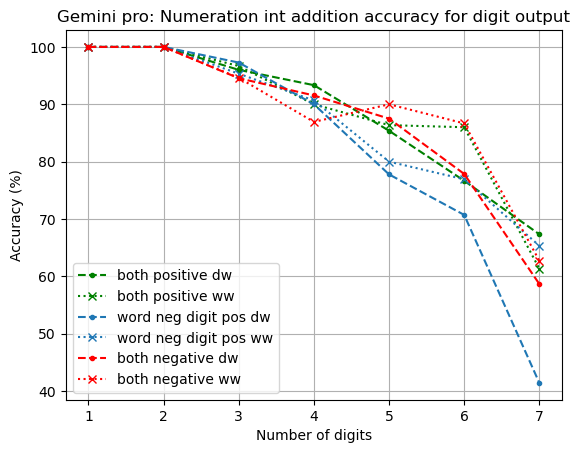

In [7]:
accuracy_digit = correct_dig_op*100/total_dig_op
digits = np.arange(1,MAX_DIGITS+1)
# plot accuracy
plt.plot(digits, accuracy_digit[0,0],marker='o',ms=3,linestyle='--',color='green',label='both positive dw')
plt.plot(digits, accuracy_digit[0,1],marker='x',linestyle=':',color='green',label='both positive ww')
plt.plot(digits, accuracy_digit[1,0],marker='o',ms=3,linestyle='--',color='#1f77b4',label='word neg digit pos dw')
plt.plot(digits, accuracy_digit[1,1],marker='x',linestyle=':',color='#1f77b4',label='word neg digit pos ww')
plt.plot(digits, accuracy_digit[2,0],marker='o',ms=3,linestyle='--',color='red',label='both negative dw')
plt.plot(digits, accuracy_digit[2,1],marker='x',linestyle=':',color='red',label='both negative ww')
plt.xlabel('Number of digits')
plt.ylabel('Accuracy (%)')
plt.title('Gemini pro: Numeration int addition accuracy for digit output')
plt.legend()
plt.grid()
plt.savefig('gemini_response/plots/Numeration_int_addition_digit_op_accuracy.png')
plt.show()

# Evaluation when output format is word

### preprocessing

In [8]:
MAX_DIGITS = 7

In [9]:
# need to prepocess the lines
processed_lines = []

rejected_lines = {'end with ?':[],'have no word form num':[]}

with open('gemini_response/Numeration_int_addition_word_op_response.txt','r') as file:
    for line in file:
        # remove spaces and newlines
        line = line.strip()
        # some lines end with a question mark, and don't contain answers reject them
        if line.endswith('?'):
            rejected_lines['end with ?'].append(line)
            continue
        # some lines are empty, reject them
        if len(line) == 0:
            continue
        # some lines don't contain a single letter, reject them
        if re.match(r'^[^a-zA-Z]*$', line):
            rejected_lines['have no word form num'].append(line)
            continue
        # some lines have **Answer:** a{digit}+b{digit} = sum {digit}, reject them
        if line.startswith('**Answer:**'):
            # remove **Answer:** from them
            line = line.replace('**Answer:**','')
            processed_lines.append(line)
            continue

        else:
            processed_lines.append(line)
        
        

In [10]:
len(processed_lines)

5942

total examples were 5942, we got 100% of the examples answered in valid format.

# evaluation

In [11]:
def get_num_digits(num):
    return len(str(num).replace('-',''))

def word2num(word):
    # strip spaces
    word = word.strip()
    # remove commas
    word = word.replace(',','')
    # get sign
    sign = word.startswith('minus')
    num = ((-1)**sign)* word_to_num(word)
    return num

def is_correct(a,b,sum):
    return a+b == sum

In [12]:
total_word_op = np.zeros((3,2,MAX_DIGITS))
correct_word_op = np.zeros((3,2,MAX_DIGITS))
# to investigate whether lines are classified correctly or not
classified_lines = {0:
                    {0: {0:[],1:[],2:[],3:[],4:[],5:[],6:[]},
                     1: {0:[],1:[],2:[],3:[],4:[],5:[],6:[]}
                    },
               1:    
                    {0: {0:[],1:[],2:[],3:[],4:[],5:[],6:[]},
                     1: {0:[],1:[],2:[],3:[],4:[],5:[],6:[]}
                    },
               2:    
                    {0: {0:[],1:[],2:[],3:[],4:[],5:[],6:[]},
                     1: {0:[],1:[],2:[],3:[],4:[],5:[],6:[]}
                    }
                }
# axis 0: 0 = both positive, 1 = word neg digit pos, 2 = both negative
# axis 1: 0 = dw, 1 = ww
# axis 2: 0-6 = number of digits-1
rejected_lines = {'error in spliting ab, sum':[],'invalid sum':[]}
for line in processed_lines:
    # strip spaces
    line = line.strip()
    # some lines have numbering at start, eg 1. a + b = sum,
    # remove the numbering and dot if present
    line = re.sub(r'^\d+\.\s*','',line)
    # some lines have * at start and end of numbers, remove them
    line = re.sub(r'\*','',line)
    # split line into operands and sum
    try:
        a_b, sum = line.split('=')[0], line.split('=')[-1]
    except ValueError:
        rejected_lines['error in spliting ab, sum'].append(line)
        break

    # split operands into a and b
    a, b = a_b.split('+')

    # convert a, b and sum to numbers  
    try:
        a = int(a)      
        a_type = 0      # 0 = digit, 1 = word
    except ValueError:
        a = word2num(a)
        a_type = 1
    
    try:
        b = int(b)
        b_type = 0      # 0 = digit, 1 = word
    except ValueError:
        b = word2num(b) 
        b_type = 1
    
    try:
        sum = word2num(sum)
    except ValueError:
        # if sum is not a word, skip this line
        rejected_lines['invalid sum'].append(line)
        continue

    # get number of digits 
    num_digits_a = get_num_digits(a)
    num_digits_b = get_num_digits(b)
    num_digits = min(num_digits_a,num_digits_b)
    # get dw or ww
    dw_or_ww = a_type*b_type # 0 = dw, 1 = ww

    if a>=0 and b>=0:
        sign_of_both = 0
    elif a<0 and b<0:
        sign_of_both = 2
    else:
        sign_of_both = 1
    
    total_word_op[sign_of_both,dw_or_ww,num_digits-1] += 1
    correct_word_op[sign_of_both,dw_or_ww,num_digits-1] += is_correct(a,b,sum)

    classified_lines[sign_of_both][dw_or_ww][num_digits-1].append((line, a, b, sum))


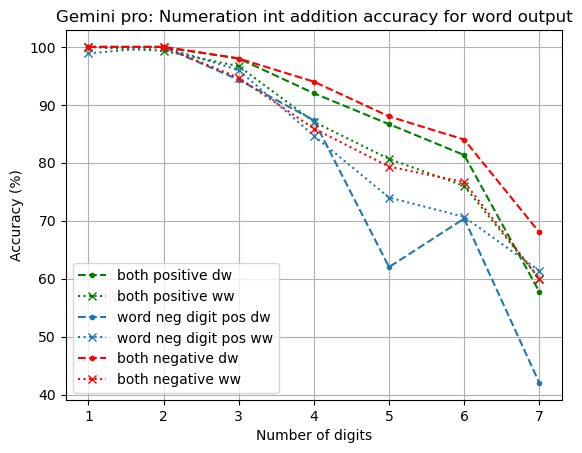

In [13]:
accuracy_word = correct_word_op*100/total_word_op
digits = np.arange(1,MAX_DIGITS+1)
# plot accuracy
plt.plot(digits, accuracy_word[0,0],marker='o',ms=3,linestyle='--',color='green',label='both positive dw')
plt.plot(digits, accuracy_word[0,1],marker='x',linestyle=':',color='green',label='both positive ww')
plt.plot(digits, accuracy_word[1,0],marker='o',ms=3,linestyle='--',color='#1f77b4',label='word neg digit pos dw')
plt.plot(digits, accuracy_word[1,1],marker='x',linestyle=':',color='#1f77b4',label='word neg digit pos ww')
plt.plot(digits, accuracy_word[2,0],marker='o',ms=3,linestyle='--',color='red',label='both negative dw')
plt.plot(digits, accuracy_word[2,1],marker='x',linestyle=':',color='red',label='both negative ww')
plt.xlabel('Number of digits')
plt.ylabel('Accuracy (%)')
plt.title('Gemini pro: Numeration int addition accuracy for word output')
plt.legend()
plt.grid()
plt.savefig('gemini_response/plots/Numeration_int_addition_word_op_accuracy.png')
plt.show()